In [1]:
#Change directory to data location
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [13]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import gridspec

In [4]:
#Read data
datav10 = xr.open_mfdataset('v10\*.nc',combine = 'by_coords')
datav925 = xr.open_mfdataset('v925\*.nc',combine = 'by_coords')
datau925 = xr.open_mfdataset('u925\*.nc',combine = 'by_coords')
datamslp = xr.open_mfdataset('mslp\*.nc',combine = 'by_coords')/100

In [5]:
#CS no-CS Classification
#u<=0
ucsidx=datau925['u'].sel(lat= slice(5,10), lon=slice(107,115), time=slice('1981-11-01T00:00:00.000000000','2021-03-31T00:00:00.000000000'))
#ucsidx=ucsidx.rolling(time=3, center=True).mean()
ucsidx=ucsidx.sel(time=ucsidx.time.dt.month.isin([1, 2, 3, 11, 12]))
ucsidx=ucsidx.mean(dim=('lat', 'lon'))

#v<0
vcsidx=datav925['v'].sel(lat= slice(5,10), lon=slice(107,115), time=slice('1981-11-01T00:00:00.000000000','2021-03-31T00:00:00.000000000'))
#vcsidx=vcsidx.rolling(time=3, center=True).mean()
vcsidx=vcsidx.sel(time=vcsidx.time.dt.month.isin([1, 2, 3, 11, 12]))
vcsidx=vcsidx.mean(dim=('lat', 'lon'))

#ws
wsidx=(vcsidx**2+ucsidx**2)**0.5

In [6]:
mslcs=datamslp.sel(lat= slice(18,22), lon=slice(105,122), time=slice('1981-11-01T00:00:00.000000000','2021-03-31T00:00:00.000000000'))
#mslcs=mslcs.rolling(time=3, center=True).mean()
mslcs=mslcs.sel(time=mslcs.time.dt.month.isin([1, 2, 3, 11, 12]))['msl']
mslcs=mslcs.mean(dim=('lat', 'lon'))

In [7]:
censidx=datav10.sel(lat= slice(-5,0), lon=slice(105,110), time=slice('1981-11-01T00:00:00.000000000','2021-03-31T00:00:00.000000000'))
#censidx=censidx.rolling(time=3, center=True).mean()
censidx=censidx.sel(time=censidx.time.dt.month.isin([1, 2, 3, 11, 12]))['v10']
censidx=censidx.mean(dim=('lat', 'lon'))

In [8]:
ucsidx=ucsidx.load()
vcsidx=vcsidx.load()
wsidx=wsidx.load()
mslcs=mslcs.load()
censidx=censidx.load()

In [9]:
import xskillscore as xs
def cor20(data1, data2, monthslc):
    corrcoef=[]
    pvalue=[]
    for i in range(-10,11):
        var1=data1.sel(time=data1.time.dt.month.isin(monthslc))
        var2=data2.sel(time=data2[data2.time.dt.month.isin(monthslc)]['time']+np.timedelta64(i,'D'))
        var2['time']=var1['time']
        #corr, pval =pearsonr(var1.values,var2.values)
        corr=xs.pearson_r(var1, var2)
        pval=xs.pearson_r_eff_p_value(var1, var2)
        corrcoef.append(corr)
        pvalue.append(pval)
    return np.array(corrcoef), np.array(pvalue)

In [10]:
#Topography data
#https://ldas.gsfc.nasa.gov/gldas/elevation
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
topo = xr.open_dataset('E:\Data\GLDASp5_elevation_025d.nc4')
topo = topo.sel(lat= slice(-10,40), lon=slice(90,130))
lattopo = topo.variables['lat'].values
lontopo = topo.variables['lon'].values

In [11]:
#Color setting
terrain =cm.get_cmap('terrain', 100)
terrain =terrain(np.linspace(0,1,100))
terrainland =terrain[20:,:]
newcolors = np.vstack((terrainland))
newcmp = ListedColormap(newcolors, name='cww')

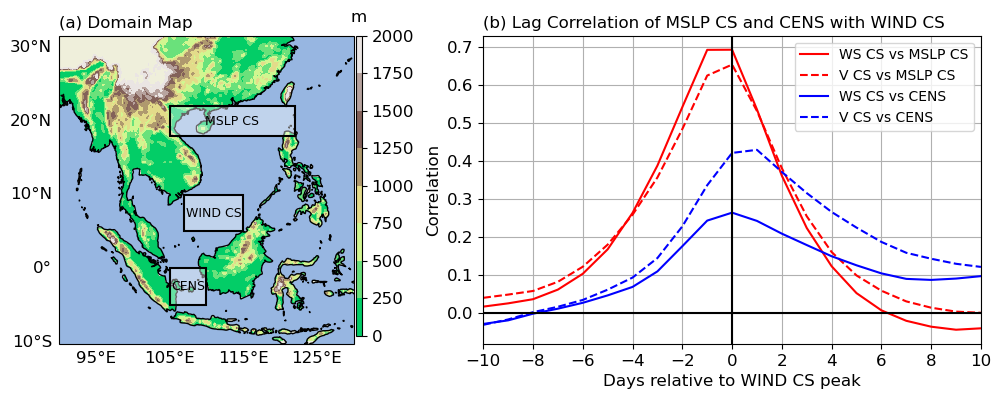

In [27]:
#Plot Map
fig=plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.6]) 
#ax0 = plt.subplot(gs[0])
ax=plt.subplot(gs[0],projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([90, 130, -10, 30])
gl=ax.gridlines(draw_labels=True,linewidth=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
gl.xlocator = tk.FixedLocator(np.arange(95,126,10))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0)

topograf=ax.contourf(lontopo, lattopo, topo['GLDAS_elevation'][0], transform=ccrs.PlateCarree(),
                                       cmap=newcmp,
                                       levels=np.arange(0,2001,250), linewidths=1
                                       )
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1, edgecolor='k')
longitude1, latitude1 = 105, -5
longitude2, latitude2 = 110, 0

ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='white', alpha=0.4, zorder=3, edgecolor='k', linewidth=0,
                                transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='none', alpha=1, zorder=3, edgecolor='k', linewidth=1.5,
                                transform=ccrs.PlateCarree()))

longitude1, latitude1 = 107, 5
longitude2, latitude2 = 115, 10

ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='white', alpha=0.4, zorder=3, edgecolor='k', linewidth=0,
                                transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='none', alpha=1, zorder=3, edgecolor='k', linewidth=1.5,
                                transform=ccrs.PlateCarree()))

longitude1, latitude1 = 105, 18
longitude2, latitude2 = 122, 22

ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='white', alpha=0.4, zorder=3, edgecolor='k', linewidth=0,
                                transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='none', alpha=1, zorder=3, edgecolor='k', linewidth=1.5,
                                transform=ccrs.PlateCarree()))

plt.text(107.5,-2.5,'CENS',fontsize=9, fontweight='medium', c='k', va='center', ha='center')
plt.text(111,7.5,'WIND CS',fontsize=9, fontweight='medium', c='k', va='center', ha='center')
plt.text(113.5,20,'MSLP CS',fontsize=9, fontweight='medium', c='k', va='center', ha='center')
plt.title("(a) Domain Map", loc='left')

cbar_ax = fig.add_axes([0.379, 0.13, 0.005, 0.75])
cbar=fig.colorbar(topograf, cax=cbar_ax, label='')
cbar.ax.set_title('m', pad=10, fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.subplot(gs[1])
plt.ylabel('Correlation', fontsize=12)
plt.xlabel('Days relative to WIND CS peak', fontsize=12)
plt.plot(np.arange(-10,11,1), cor20(wsidx, mslcs, [12,1,2])[0], c='r', label='WS CS vs MSLP CS')
plt.plot(np.arange(-10,11,1), -1*cor20(vcsidx, mslcs, [12,1,2])[0], c='r', linestyle='--', label='V CS vs MSLP CS')
plt.plot(np.arange(-10,11,1), -1*cor20(wsidx, censidx, [12,1,2])[0], c='b', label='WS CS vs CENS')
plt.plot(np.arange(-10,11,1), cor20(vcsidx, censidx, [12,1,2])[0], c='b', linestyle='--', label='V CS vs CENS')
#plt.plot(np.arange(-10,11,1), cor20(ucsidx, censidx, [12,1,2])[0], c='k', linestyle='dotted', label='U CS vs CENS')
#plt.plot(np.arange(-30,31,1), cor20(csindex, sstindex, [12,1,2])[0], c='b', label='SPL vs CS')
#plt.scatter(np.arange(-30,31,1), cor20(censindex, sstindex, [12,1,2])[0], s=30*(cor20(censindex, sstindex, [12,1,2])[1]<0.01), 
#            marker='*', c='k', label='Signifikan pada tingkat kepercayaan 99%')
#plt.scatter(np.arange(-30,31,1), cor20(csindex, sstindex, [12,1,2])[0], s=30*(cor20(csindex, sstindex, [12,1,2])[1]<0.01), 
#            marker='*', c='b')
plt.title("(b) Lag Correlation of MSLP CS and CENS with WIND CS ", loc='left')
plt.xticks(np.arange(-10,11,2), fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend()
#plt.ylim([-0.05,0.45])
plt.xlim([-10,10])
plt.axvline(x=0, c='k')
plt.axhline(y=0, c='k')
fig.subplots_adjust(wspace=0.3)
#plt.savefig('E:\. Disertasi S3 Bismillah\Publikasi\Paper Hubungan CS dan CENS\Gambar/1_Domain and Correlation.jpg', dpi=300, bbox_inches='tight')